In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import os

In [2]:
!pip install pyedflib

In [3]:
import pyedflib
import numpy as np

def _read_py_function(filename, num_channels=16):
    # Open the EDF file
    f = pyedflib.EdfReader(filename)
    
    # Get the number of channels and the signal labels
    n_channels = f.signals_in_file
    print(f"Total channels in file: {n_channels}")
    
    # Ensure that we are fetching only the desired number of channels (16 in this case)
    if num_channels > n_channels:
        raise ValueError(f"The file contains only {n_channels} channels, but {num_channels} were requested.")
    
    # Initialize eeg_data to store only the first `num_channels`
    eeg_data = np.zeros((num_channels, f.getNSamples()[0]), dtype=np.float32)
    
    # Read only the first `num_channels` channels
    for i in range(num_channels):
        eeg_data[i, :] = f.readSignal(i)

    n_samples = f.getNSamples()[0]
    reminder = int(n_samples % 160)
    
    # Print statement to check values
    print(f"Original n_samples: {n_samples}")
    print(f"Reminder: {reminder}")
    
    n_samples -= reminder
    seconds = int(n_samples / 160)
    
    # Extract person_id from the filename
    path = filename.split("\\")
    person_id = int(path[-1].partition("S")[2].partition("R")[0])
    
    # Create one-hot encoded labels
    label = np.zeros(10, dtype=bool)
    label[person_id-1] = 1
    labels = np.tile(label, (seconds, 1))
    
    # Normalization step
    for i in range(num_channels):
        channel_data = eeg_data[i, :]
        mean_i = np.mean(channel_data)  # Compute mean of channel i
        std_i = np.std(channel_data)    # Compute standard deviation of channel i
        
        if std_i != 0:  # Avoid division by zero
            eeg_data[i, :] = (channel_data - mean_i) / std_i  # Normalize channel i

    # Transpose the data to shape (n_samples, n_channels)
    eeg_data = eeg_data.T
    
    if reminder > 0:
        eeg_data = eeg_data[:-reminder, :]
    
    # Split the data into 160-sample chunks
    intervals = np.linspace(0, n_samples, num=seconds, endpoint=False, dtype=int)
    eeg_data = np.split(eeg_data, intervals)
    del eeg_data[0]
    eeg_data = np.array(eeg_data)
    
    return eeg_data, labels


In [4]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

def load_eeg_data_with_pyedflib(data_path, max_subjects=10):
    # Initialize the global variables
    global subject_data, all_train_data, all_train_labels, all_test_data, all_test_labels
    global train_data, val_data, train_labels, val_labels

    # Initialize the variables before using them
    subject_data = {}
    all_train_data = []
    all_train_labels = []
    all_test_data = []
    all_test_labels = []

    subject_count = 0  # Counter to track the number of subjects processed

    for subject_dir in os.listdir(data_path):
        subject_path = os.path.join(data_path, subject_dir)
        if os.path.isdir(subject_path):
            print(f"Processing subject: {subject_dir}")
            subject_data[subject_dir] = {}
            for recording_file in os.listdir(subject_path):
                recording_path = os.path.join(subject_path, recording_file)
                if recording_file.endswith('.edf'):
                    recording_id = os.path.splitext(recording_file)[0]
                    print(f"Loading recording: {recording_file}")

                    try:
                        #eeg_data, labels = _read_py_function(recording_path)
                        eeg_data, labels = _read_py_function(recording_path)

                        print(f"Data shape after processing: {eeg_data.shape}")
                        print(f"Labels shape: {labels.shape}")

                        train_data, test_data, train_labels, test_labels = train_test_split(
                            eeg_data, labels, test_size=0.1, random_state=42
                        )
                        
                        all_train_data.append(train_data)
                        all_train_labels.append(train_labels)
                        all_test_data.append(test_data)
                        all_test_labels.append(test_labels)

                    except Exception as e:
                        print(f"Error loading {recording_file}: {e}")

            subject_count += 1  # Increment the subject counter

            # Stop processing once the desired number of subjects is reached
            if subject_count >= max_subjects:
                print(f"Processed {max_subjects} subjects. Stopping further processing.")
                break

    print(f"Train data list length: {len(all_train_data)}")
    print(f"Train labels list length: {len(all_train_labels)}")
    print(f"Test data list length: {len(all_test_data)}")
    print(f"Test labels list length: {len(all_test_labels)}")

    if all_train_data and all_train_labels:
        all_train_data = np.concatenate(all_train_data, axis=0)
        all_train_labels = np.concatenate(all_train_labels, axis=0)
    else:
        print("No training data loaded.")
        return None, None, None, None, None, None

    if all_test_data and all_test_labels:
        all_test_data = np.concatenate(all_test_data, axis=0)
        all_test_labels = np.concatenate(all_test_labels, axis=0)
    else:
        print("No test data loaded.")
        return None, None, None, None, None, None

    if len(all_train_data) == 0 or len(all_train_labels) == 0:
        print("No data available for splitting into training and validation sets.")
        return None, None, None, None, None, None

    # Split train data further into training and validation sets
    train_data, val_data, train_labels, val_labels = train_test_split(
        all_train_data, all_train_labels, test_size=0.25, random_state=42
    )

    return train_data, train_labels, val_data, val_labels, all_test_data, all_test_labels


In [5]:
data_path = r"C:\Users\akhileshsing2024\Downloads\eeg-motor-movementimagery-dataset-1.0.0\files"
train_data, train_labels, val_data, val_labels, test_data, test_labels = load_eeg_data_with_pyedflib(data_path)
# Access global variables directly if needed
print(f"Train data shape: {train_data.shape if train_data is not None else 'None'}")
print(f"Validation data shape: {val_data.shape if val_data is not None else 'None'}")
print(f"Test data shape: {test_data.shape if test_data is not None else 'None'}")

Processing subject: S001
Loading recording: S001R01.edf
Total channels in file: 64
Original n_samples: 9760
Reminder: 0
Data shape after processing: (61, 160, 16)
Labels shape: (61, 10)
Loading recording: S001R02.edf
Total channels in file: 64
Original n_samples: 9760
Reminder: 0
Data shape after processing: (61, 160, 16)
Labels shape: (61, 10)
Loading recording: S001R03.edf
Total channels in file: 64
Original n_samples: 20000
Reminder: 0
Data shape after processing: (125, 160, 16)
Labels shape: (125, 10)
Loading recording: S001R04.edf
Total channels in file: 64
Original n_samples: 20000
Reminder: 0
Data shape after processing: (125, 160, 16)
Labels shape: (125, 10)
Loading recording: S001R05.edf
Total channels in file: 64
Original n_samples: 20000
Reminder: 0
Data shape after processing: (125, 160, 16)
Labels shape: (125, 10)
Loading recording: S001R06.edf
Total channels in file: 64
Original n_samples: 20000
Reminder: 0
Data shape after processing: (125, 160, 16)
Labels shape: (125, 1

In [6]:
import tensorflow as tf

def eeg_biometric_identification_model_cnn(input_shape, n_classes, keep_prob=0.5):
    inputs = tf.keras.Input(shape=input_shape)

    # 1D Convolutional Layers
    conv1 = tf.keras.layers.Conv1D(filters=128, kernel_size=2, strides=1, padding='same', activation='relu')(inputs)
    conv2 = tf.keras.layers.Conv1D(filters=256, kernel_size=2, strides=1, padding='same', activation='relu')(conv1)
    conv3 = tf.keras.layers.Conv1D(filters=512, kernel_size=2, strides=1, padding='same', activation='relu')(conv2)
    conv4 = tf.keras.layers.Conv1D(filters=1024, kernel_size=2, strides=1, padding='same', activation='relu')(conv3)

    # Additional CNN layers to replace LSTMs
    conv5 = tf.keras.layers.Conv1D(filters=1024, kernel_size=2, strides=1, padding='same', activation='relu')(conv4)
    conv6 = tf.keras.layers.Conv1D(filters=1024, kernel_size=2, strides=1, padding='same', activation='relu')(conv5)

    # Flatten the convolution output before feeding into fully connected layers
    flatten = tf.keras.layers.Flatten()(conv6)

    # Fully connected layer with 192 neurons and dropout
    fc1 = tf.keras.layers.Dense(units=192, activation='relu')(flatten)
    dropout_fc1 = tf.keras.layers.Dropout(rate=1 - keep_prob)(fc1)

    # Additional fully connected layers
    fc2 = tf.keras.layers.Dense(units=192, activation='relu')(dropout_fc1)
    fc3 = tf.keras.layers.Dense(units=192, activation='relu')(fc2)

    # Output layer (Softmax for classification)
    output = tf.keras.layers.Dense(n_classes, activation='softmax')(fc3)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=output)

    return model

# Example usage
input_shape = (160, 16)  # 160 samples, 64 channels (1-second EEG recording)
n_classes = 10  # Number of subjects
keep_prob = 0.5  # Dropout rate

model = eeg_biometric_identification_model_cnn(input_shape, n_classes, keep_prob=keep_prob)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 160, 128)       │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 160, 256)       │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 160, 512)       │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 160, 1024)      │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 160, 1024)      │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 160, 1024)      │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 163840)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 192)            │    31,457,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 192)            │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 192)            │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,112,138 (141.57 MB)

 Trainable params: 37,112,138 (141.57 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
checkpoint_path = "C:/Users/akhileshsing2024/Desktop/Epochs/best_model/CNN_16_1.weights.h5"  # Save the best model in the current directory
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,  # Save only the best model
                                                 monitor='val_loss',  # Monitor validation loss
                                                 mode='min',  # Save the model with the lowest validation loss
                                                 verbose=1)

# Training the model
with tf.device('/GPU:0'):  # Ensure training uses the GPU
    history = model.fit(train_data, train_labels, 
                        epochs=20, 
                        validation_data=(val_data, val_labels), 
                        batch_size=80,  
                        callbacks=[cp_callback]) 

Epoch 1/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2516 - loss: 1.9266
Epoch 1: val_loss improved from inf to 0.99959, saving model to C:/Users/akhileshsing2024/Desktop/Epochs/best_model/CNN_16_1.weights.h5
135/135 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.2525 - loss: 1.9242 - val_accuracy: 0.6026 - val_loss: 0.9996
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5881 - loss: 1.0326
Epoch 2: val_loss improved from 0.99959 to 0.67631, saving model to C:/Users/akhileshsing2024/Desktop/Epochs/best_model/CNN_16_1.weights.h5
135/135 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.5883 - loss: 1.0321 - val_accuracy: 0.7701 - val_loss: 0.6763
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7051 - loss: 0.7633
Epoch 3: val_loss improved from 0.67631 to 0.55371, saving model to C:/Users/akhileshsing2024/Desktop/Epochs/best_model/CNN_16_1.weights.h5
135/135 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.7053 - loss: 0.7629 - val_accuracy: 0

In [8]:
# Save the training history as a numpy file
np.save("history_CNN_16.npy", history.history)

# Load the training history
history = np.load("history_CNN_16.npy", allow_pickle=True).item()

# Ensure history is a dictionary
if type(history) is not dict:
    history = history.history

# Find the epoch with the highest validation accuracy
max_value = max(history['val_accuracy'])
print(f"Max Validation Accuracy: {max_value}")

max_index = history['val_accuracy'].index(max_value)
print(f"Best Epoch Index: {max_index}")
print(f"Corresponding Training Accuracy: {history['accuracy'][max_index]}")

# Load the best checkpoint based on validation accuracy
model.load_weights(checkpoint_path)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x=test_data, y=test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Max Validation Accuracy: 0.9849498271942139
Best Epoch Index: 16
Corresponding Training Accuracy: 0.9886659383773804
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 216ms/step - accuracy: 0.9795 - loss: 0.2169
Test Loss: 0.16300608217716217
Test Accuracy: 0.9835293889045715


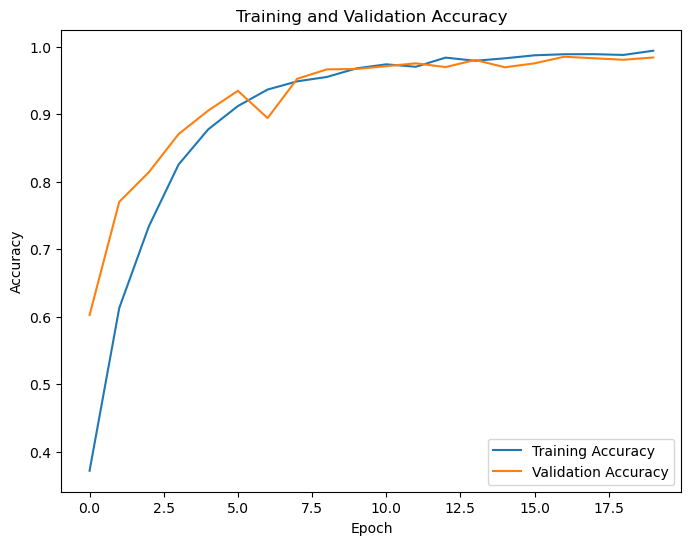

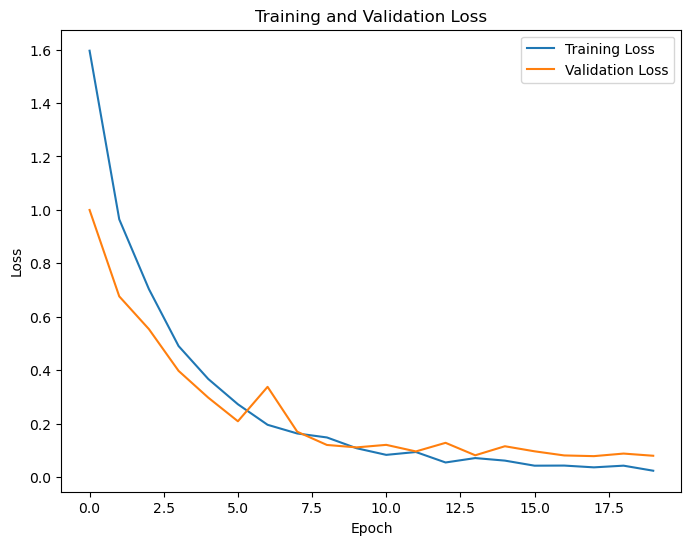

In [9]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#plt.savefig("accuracy_plot.png")  # Save the accuracy plot
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
#plt.savefig("loss_plot.png")  # Save the loss plot
plt.show()

54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step
Confusion Matrix:
[[167   0   0   0   0   0   0   3   0   0]
 [  0 166   0   0   0   0   0   0   4   0]
 [  3   0 163   2   0   0   0   2   0   0]
 [  0   0   2 163   0   0   0   1   2   2]
 [  0   0   0   0 170   0   0   0   0   0]
 [  0   0   0   0   0 170   0   0   0   0]
 [  0   0   0   0   0   0 170   0   0   0]
 [  0   0   0   0   0   0   0 170   0   0]
 [  0   0   0   0   0   0   0   0 170   0]
 [  0   0   0   6   0   0   0   1   0 163]]


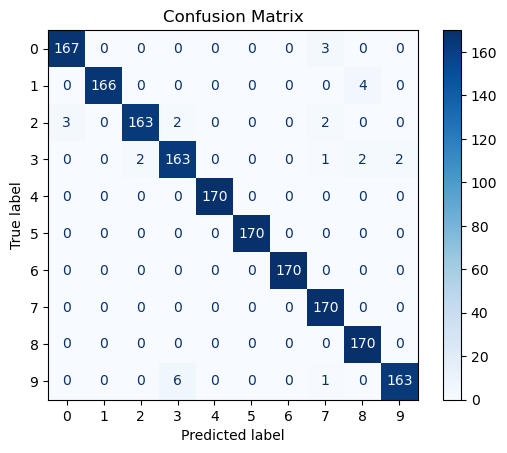

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get the predictions from the model on the test data
predictions = model.predict(test_data)

# Convert the predicted probabilities into class predictions (argmax over class probabilities)
predicted_classes = np.argmax(predictions, axis=1)

# Convert the one-hot encoded test labels back to their original class labels
true_classes = np.argmax(test_labels, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print confusion matrix
print(f"Confusion Matrix:\n{cm}")

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(n_classes))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()